### Random Forest를 partial linear 모형으로 세워서 vix를 예측해보기
- $y_{t} = y_{t-1} + y_{t-1}^{weekly} + y_{t-1}^{monthly} + y_{t-1}^{quarterly} + f(X_{t-1})$
    - $y_{t-1}^{weekly} = \frac{1}{5}\sum^{5}_{j=1}y_{t-j}$
    - $y_{t-1}^{monthly} = \frac{1}{22}\sum^{22}_{j=1}y_{t-j}$
- random forest의 경우 default value로 진행하기
- 동일하게 rolling으로 진행
- random seed를 하나로 고정하고 진행 → 나의 경우 42

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager, rcParams
font_name = font_manager.FontProperties(fname = "c:/windows/fonts/malgun.ttf").get_name()
rc('font', family = font_name)
rcParams["axes.unicode_minus"] = False

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.ensemble import RandomForestRegressor
import xgboost
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle

#### Import data


In [9]:
# Line 7~16
df = pd.read_excel("../data/dataset_HARX(14).xlsx")
RAW_DF = df.copy()
RAW_DF.set_index(["Code"], inplace = True)
df = df.iloc[66:, :]
date = df["Code"].to_numpy() # The date
df.set_index(["Code"], inplace = True)
df = df.iloc[:5740, :] # to 1990-04-06 ~ 2013-01-15
                    # Fernandes et al.(2014) : 1990-04-05 ~ 2013-01-15
                    # But some values are NaN at 1990-04-05
                    # So I dropped 1990-04-05 #TODO: 해당 업은 아래 `run_pl_rf`에서 수행하도록 바꿨음. Forecast horizon을 맞추기 위해서
                                                # 최종적으로 forecast horizon은 Fernandes와 동일함
data = df.to_numpy() # To matrix
# data = data[66:, :] # obsolete line if dropna performed correctly # TODO: 위의 TODO 주석으로 인해서 이 부분은 주석처리함

In [12]:
df

,lnVIX,HAR_5day,HAR_10day,HAR_22day,HAR_66day,SP_1day,SP_5day,SP_10day,SP_22day,SP_66day,...,SP_66day.1,S&PCOMP(MV).1,Oil_1day.1,Oil_5day.1,Oil_10day.1,Oil_22day.1,Oil_66day.1,T10Y3M.1,Credit Spread.1,USG6WIC(TW).1
Code,,,,,,,,,,,,,,,,,,,,,
1990-04-05,3.054473,3.055005,3.021329,2.998303,3.094873,-0.001056,-0.000176,0.014902,0.008252,-0.054152,...,NaN,-0.007446,-0.025950,-0.015053,-0.009059,-0.087096,NaN,0.54,0.85,-0.000665
1990-04-06,3.080073,3.074592,3.027489,3.004229,3.097588,-0.001909,0.000412,0.008445,0.009246,-0.053473,...,-0.054152,-0.001156,-0.017853,-0.030413,-0.028914,-0.091889,-0.163882,0.55,0.84,-0.000785
1990-04-09,3.104587,3.069806,3.040446,3.009772,3.099840,0.003786,0.007852,0.011016,0.003228,-0.041036,...,-0.053473,-0.001902,-0.014516,-0.057332,-0.062742,-0.088881,-0.212328,0.54,0.84,-0.001649
1990-04-10,3.076851,3.081678,3.043631,3.012783,3.100986,0.002048,-0.004579,0.001668,0.012177,-0.029184,...,-0.041036,0.003790,-0.037780,-0.104927,-0.103950,-0.119469,-0.238641,0.50,0.83,-0.001974
1990-04-11,2.875258,3.038248,3.032740,3.007148,3.098965,-0.000439,0.002430,-0.000234,0.009551,-0.034127,...,-0.029184,0.002046,-0.042088,-0.138187,-0.147015,-0.144570,-0.266532,0.55,0.80,0.000792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-09,2.625393,2.633199,2.780547,2.796836,2.800323,0.002652,-0.000958,0.023799,0.032755,0.010507,...,0.008726,-0.003250,-0.000429,0.014381,0.049402,0.058239,0.007219,1.82,0.93,0.001932
2013-01-10,2.601949,2.617933,2.743803,2.789365,2.798287,0.007569,0.008699,0.036166,0.037407,0.014457,...,0.010507,0.002655,-0.000537,-0.000215,0.049429,0.076308,0.013082,1.82,0.94,0.003604
2013-01-11,2.592265,2.611018,2.706142,2.781026,2.796994,-0.000048,0.003798,0.037338,0.037021,0.007261,...,0.014457,0.007570,0.007704,0.009639,0.030738,0.087845,0.062452,1.85,0.93,-0.010450


In [13]:
df.head(2)

,lnVIX,HAR_5day,HAR_10day,HAR_22day,HAR_66day,SP_1day,SP_5day,SP_10day,SP_22day,SP_66day,...,SP_66day.1,S&PCOMP(MV).1,Oil_1day.1,Oil_5day.1,Oil_10day.1,Oil_22day.1,Oil_66day.1,T10Y3M.1,Credit Spread.1,USG6WIC(TW).1
Code,,,,,,,,,,,,,,,,,,,,,
1990-04-05,3.054473,3.055005,3.021329,2.998303,3.094873,-0.001056,-0.000176,0.014902,0.008252,-0.054152,...,NaN,-0.007446,-0.025950,-0.015053,-0.009059,-0.087096,NaN,0.54,0.85,-0.000665
1990-04-06,3.080073,3.074592,3.027489,3.004229,3.097588,-0.001909,0.000412,0.008445,0.009246,-0.053473,...,-0.054152,-0.001156,-0.017853,-0.030413,-0.028914,-0.091889,-0.163882,0.55,0.84,-0.000785


In [14]:
df.tail(2)

,lnVIX,HAR_5day,HAR_10day,HAR_22day,HAR_66day,SP_1day,SP_5day,SP_10day,SP_22day,SP_66day,...,SP_66day.1,S&PCOMP(MV).1,Oil_1day.1,Oil_5day.1,Oil_10day.1,Oil_22day.1,Oil_66day.1,T10Y3M.1,Credit Spread.1,USG6WIC(TW).1
Code,,,,,,,,,,,,,,,,,,,,,
2013-01-14,2.604170,2.607063,2.654235,2.774609,2.796113,-0.000931,0.005995,0.047518,0.029562,0.006652,...,0.007261,-0.000046,-0.002775,0.005036,0.029173,0.089385,0.019972,1.82,0.92,-0.002825
2013-01-15,2.606387,2.606033,2.625725,2.767197,2.794462,0.001128,0.010370,0.031846,0.030242,0.011242,...,0.006652,-0.000935,0.006180,0.010143,0.036124,0.092881,0.046308,1.81,0.93,-0.000503


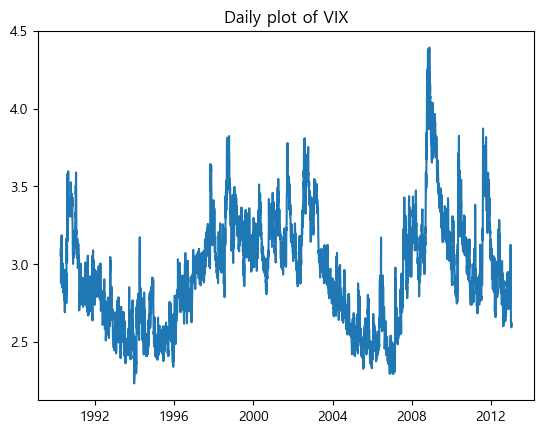

In [15]:
# plot vix
plt.plot(df["lnVIX"])
plt.title("Daily plot of VIX")
plt.show()

#### set the params for forecasting

In [16]:
npred = 3240

random_state = 42

params_for_rf = {"n_estimators" : 100, "random_state" : random_state}
params_for_xgb = {"tree_method" : "exact", "random_state" : random_state}

linear_variables = ["lnVIX", "HAR_5day", "HAR_10day", "HAR_22day", "HAR_66day"]
nonlinear_variables = list(df.columns[5:])
target_variable = "lnVIX"

# lag = 1

#### Perform the forecasting

In [17]:
# tmp_data = df.loc[date_window]

# # perform dropna due to 1990-04-05 / at that days, some variables contain np.nan
# tmp_data.dropna(inplace = True)

# # update date_window in case of dropna
# date_window = date_window[np.isin(date_window, tmp_data.index)]

# # set the X and Y
# Y = tmp_data.loc[:, target_variable]
# X = tmp_data.loc[:, linear_variables + nonlinear_variables]

# # set the target X and y
# X_window = date_window[:-lag]
# y_window = date_window[lag:]

# X_train = X.loc[X_window]
# y_train = Y.loc[y_window]

# # split the X to linear and nonlinear
# X_linear_train = X_train.loc[:, linear_variables]
# X_nonlinear_train = X_train.loc[:, nonlinear_variables]

# # Set the window for test
# X_test_window = date_window[-lag]
# y_test_window = date[(np.where(date == pd.to_datetime(X_test_window))[0] + lag)[0]]

# X_linear_test = tmp_data.loc[X_test_window:X_test_window, linear_variables]
# X_nonlinear_test = tmp_data.loc[X_test_window:X_test_window, nonlinear_variables]

# # Apply the Robison's estimator
# ## 1. extract linear residual
# RF_X_linear_residual = []
# XGB_X_linear_residual = []

# for idx in range(X_linear_train.shape[1]):
    
#     tmp_X_linear = X_linear_train.iloc[:, idx:idx+1]

#     # Random Forest
#     RF_for_residual_X_linear = RandomForestRegressor(**params_for_rf)
#     RF_for_residual_X_linear.fit(X = X_nonlinear_train, y = tmp_X_linear.values.ravel())

#     tmp_RF_X_linear_residual = tmp_X_linear.iloc[:, 0] - RF_for_residual_X_linear.predict(X_nonlinear_train)
#     RF_X_linear_residual.append(tmp_RF_X_linear_residual)

#     # XGBoost
#     XGB_for_residual_X_linear = xgboost.XGBRegressor(**params_for_xgb)
#     XGB_for_residual_X_linear.fit(X = X_nonlinear_train, y = tmp_X_linear.values.ravel())

#     tmp_XGB_X_linear_residual = tmp_X_linear.iloc[:, 0] - XGB_for_residual_X_linear.predict(X_nonlinear_train)
#     XGB_X_linear_residual.append(tmp_XGB_X_linear_residual)

# RF_X_linear_residual = pd.concat(RF_X_linear_residual, axis = 1)
# XGB_X_linear_residual = pd.concat(XGB_X_linear_residual, axis = 1)

# ## 2. extract y residual
# # Random Forest
# RF_for_residual_y = RandomForestRegressor(**params_for_rf)
# RF_for_residual_y.fit(X = X_nonlinear_train, y = y_train.values.ravel())
# RF_y_residual = y_train - RF_for_residual_y.predict(X_nonlinear_train)

# # XGBoost
# XGB_for_residual_y = xgboost.XGBRegressor(**params_for_xgb)
# XGB_for_residual_y.fit(X = X_nonlinear_train, y = y_train.values.ravel())
# XGB_y_residual = y_train - XGB_for_residual_y.predict(X_nonlinear_train)

# ## 3. Get the beta
# RF_beta = pd.DataFrame(index = X_window, columns = RF_X_linear_residual.columns)
# XGB_beta = pd.DataFrame(index = X_window, columns = XGB_X_linear_residual.columns)

# RF_OLS = sm.OLS(endog = RF_y_residual.values, exog = RF_X_linear_residual.values).fit()
# XGB_OLS = sm.OLS(endog = XGB_y_residual.values, exog = XGB_X_linear_residual.values).fit()

# RF_beta = RF_OLS.params
# XGB_beta = XGB_OLS.params

# ## 4. Estimate RandomForest and XGBoost
# RF_residual = y_train.ravel() - (X_linear_train @ RF_beta).ravel()
# XGB_residual = y_train.ravel() - (X_linear_train @ XGB_beta).ravel()

# RF_ = RandomForestRegressor(**params_for_rf)
# RF_.fit(X = X_nonlinear_train, y = RF_residual)

# XGB_ = xgboost.XGBRegressor(**params_for_xgb)
# XGB_.fit(X = X_nonlinear_train, y = XGB_residual)

# ## 5. Get the prediction
# RF_pred = X_linear_test @ RF_beta + RF_.predict(X_nonlinear_test)
# XGB_pred = X_linear_test @ XGB_beta + XGB_.predict(X_nonlinear_test)

# RF_pred.index = [y_test_window]
# XGB_pred.index = [y_test_window]

# RF_pred.name = "VIX_pred_RF"
# XGB_pred.name = "VIX_pred_XGB"

In [18]:
"""define the func `run_pl_rf`"""
def run_pl_rf(date_window, date, lag, df, linear_variables, nonlinear_variables, target_variable):

    tmp_data = df.loc[date_window]

    # perform dropna due to 1990-04-05 / at that days, some variables contain np.nan
    tmp_data.dropna(inplace = True)

    # update date_window in case of dropna
    date_window = date_window[np.isin(date_window, tmp_data.index)]

    # set the X and Y
    Y = tmp_data.loc[:, target_variable]
    X = tmp_data.loc[:, linear_variables + nonlinear_variables]

    # set the target X and y
    X_window = date_window[:-lag]
    y_window = date_window[lag:]

    X_train = X.loc[X_window]
    y_train = Y.loc[y_window]

    # split the X to linear and nonlinear
    X_linear_train = X_train.loc[:, linear_variables]
    X_nonlinear_train = X_train.loc[:, nonlinear_variables]

    # Set the window for test
    # X_test_window = date_window[-lag]
    X_test_window = date_window[-1]
    y_test_window = date[(np.where(date == pd.to_datetime(X_test_window))[0] + lag)[0]]

    print(X_test_window, y_test_window)

    X_linear_test = tmp_data.loc[X_test_window:X_test_window, linear_variables]
    X_nonlinear_test = tmp_data.loc[X_test_window:X_test_window, nonlinear_variables]

    # # Apply the Robison's estimator
    # ## 1. extract linear residual
    # RF_X_linear_residual = []
    # XGB_X_linear_residual = []

    # for idx in range(X_linear_train.shape[1]):
        
    #     tmp_X_linear = X_linear_train.iloc[:, idx:idx+1]

    #     # Random Forest
    #     RF_for_residual_X_linear = RandomForestRegressor(**params_for_rf)
    #     RF_for_residual_X_linear.fit(X = X_nonlinear_train, y = tmp_X_linear.values.ravel())

    #     tmp_RF_X_linear_residual = tmp_X_linear.iloc[:, 0] - RF_for_residual_X_linear.predict(X_nonlinear_train)
    #     RF_X_linear_residual.append(tmp_RF_X_linear_residual)

    #     # XGBoost
    #     XGB_for_residual_X_linear = xgboost.XGBRegressor(**params_for_xgb)
    #     XGB_for_residual_X_linear.fit(X = X_nonlinear_train, y = tmp_X_linear.values.ravel())

    #     tmp_XGB_X_linear_residual = tmp_X_linear.iloc[:, 0] - XGB_for_residual_X_linear.predict(X_nonlinear_train)
    #     XGB_X_linear_residual.append(tmp_XGB_X_linear_residual)

    # RF_X_linear_residual = pd.concat(RF_X_linear_residual, axis = 1)
    # XGB_X_linear_residual = pd.concat(XGB_X_linear_residual, axis = 1)

    # ## 2. extract y residual
    # # Random Forest
    # RF_for_residual_y = RandomForestRegressor(**params_for_rf)
    # RF_for_residual_y.fit(X = X_nonlinear_train, y = y_train.values.ravel())
    # RF_y_residual = y_train - RF_for_residual_y.predict(X_nonlinear_train)

    # # XGBoost
    # XGB_for_residual_y = xgboost.XGBRegressor(**params_for_xgb)
    # XGB_for_residual_y.fit(X = X_nonlinear_train, y = y_train.values.ravel())
    # XGB_y_residual = y_train - XGB_for_residual_y.predict(X_nonlinear_train)

    # ## 3. Get the beta
    # RF_beta = pd.DataFrame(index = X_window, columns = RF_X_linear_residual.columns)
    # XGB_beta = pd.DataFrame(index = X_window, columns = XGB_X_linear_residual.columns)

    # RF_OLS = sm.OLS(endog = RF_y_residual.values, exog = RF_X_linear_residual.values).fit()
    # XGB_OLS = sm.OLS(endog = XGB_y_residual.values, exog = XGB_X_linear_residual.values).fit()

    # RF_beta = RF_OLS.params
    # XGB_beta = XGB_OLS.params

    # ## 4. Estimate RandomForest and XGBoost
    # RF_residual = y_train.ravel() - (X_linear_train @ RF_beta).ravel()
    # XGB_residual = y_train.ravel() - (X_linear_train @ XGB_beta).ravel()

    # RF_ = RandomForestRegressor(**params_for_rf)
    # RF_.fit(X = X_nonlinear_train, y = RF_residual)

    # XGB_ = xgboost.XGBRegressor(**params_for_xgb)
    # XGB_.fit(X = X_nonlinear_train, y = XGB_residual)

    # ## 5. Get the prediction
    # RF_pred = X_linear_test @ RF_beta + RF_.predict(X_nonlinear_test)
    # XGB_pred = X_linear_test @ XGB_beta + XGB_.predict(X_nonlinear_test)

    # RF_pred.index = [y_test_window]
    # XGB_pred.index = [y_test_window]

    # RF_pred.name = "VIX_pred_RF"
    # XGB_pred.name = "VIX_pred_XGB"

    # return RF_pred, XGB_pred, RF_beta, XGB_beta

In [19]:
df.loc[datetime(2000, 2, 28), "lnVIX"]

3.205993199037187

In [20]:
df.iloc[2490:2510]

,lnVIX,HAR_5day,HAR_10day,HAR_22day,HAR_66day,SP_1day,SP_5day,SP_10day,SP_22day,SP_66day,...,SP_66day.1,S&PCOMP(MV).1,Oil_1day.1,Oil_5day.1,Oil_10day.1,Oil_22day.1,Oil_66day.1,T10Y3M.1,Credit Spread.1,USG6WIC(TW).1
Code,,,,,,,,,,,,,,,,,,,,,
2000-02-14,3.193763,3.143038,3.129849,3.123174,3.108205,0.002031,-0.024378,-0.003247,-0.029986,0.017901,...,0.007315,-0.021194,0.000340,0.021285,0.078402,0.133143,0.235189,0.97,0.62,-0.000576
2000-02-15,3.132010,3.158169,3.127563,3.125640,3.108648,0.008675,-0.027901,-0.005143,-0.033407,0.020602,...,0.017901,0.002035,0.027142,0.061348,0.090232,0.140688,0.230193,0.88,0.63,0.006123
2000-02-16,3.157426,3.163427,3.129236,3.133769,3.109606,-0.010309,-0.017169,-0.015339,-0.054332,0.004485,...,0.020602,0.008675,-0.006301,0.070277,0.063164,0.118906,0.205748,0.81,0.64,-0.001909
2000-02-17,3.142858,3.164292,3.134372,3.137169,3.110634,0.000425,-0.020371,-0.026100,-0.047051,-0.005603,...,0.004485,-0.010313,-0.000333,0.043529,0.086860,0.069944,0.211153,0.83,0.63,-0.004214
2000-02-18,3.258097,3.176831,3.153190,3.145344,3.112664,-0.030847,-0.030026,-0.056526,-0.078420,-0.035253,...,-0.005603,0.000442,-0.019829,0.001019,0.049758,0.020923,0.167764,0.84,0.62,0.000576
2000-02-22,3.252697,3.188618,3.165828,3.153212,3.116014,0.004507,-0.027550,-0.051928,-0.066793,-0.048995,...,-0.035253,-0.030844,0.001696,0.002375,0.023660,-0.001016,0.160667,0.74,0.61,0.002873
2000-02-23,3.173460,3.196908,3.177538,3.159464,3.117996,0.006281,-0.029944,-0.057845,-0.057595,-0.036101,...,-0.048995,0.004506,0.003721,-0.021046,0.040302,-0.001350,0.141959,0.54,0.62,-0.011833
2000-02-24,3.193763,3.204175,3.183801,3.160046,3.121180,-0.005350,-0.024984,-0.042153,-0.034922,-0.051488,...,-0.036101,0.006283,-0.007795,-0.022541,0.047736,0.041333,0.099743,0.62,0.61,0.001161
2000-02-25,3.226844,3.220972,3.192632,3.164158,3.125371,-0.014940,-0.040349,-0.060720,-0.055909,-0.064362,...,-0.051488,-0.002921,0.019542,-0.002666,0.040864,0.074082,0.149822,0.55,0.61,0.006168


In [21]:
from functools import reduce

RF_prediction_dict = {}
XGB_prediction_dict = {}

RF_betas_dict = {}
XGB_betas_dict = {}

RF_rmse_dict = {}
XGB_rmse_dict = {}

RF_mae_dict = {}
XGB_mae_dict = {}

for lag in [1, 5, 10, 22][:]:

    print("{0:=^30}".format(f" Start {lag}-ahead forecast "))

    RF_prediction = []
    XGB_prediction = []

    RF_betas = []
    XGB_betas = []
    for i in range(npred, 0, -1)[:]:
        
        date_window = date[(npred - i):(data.shape[0] - i)]

        pred_idx = npred - i

        # perform the forecast
        # RF_pred, XGB_pred, RF_beta, XGB_beta = run_pl_rf(date_window, date, lag, df
        #                                                 , linear_variables, nonlinear_variables
        #                                                 , target_variable)
        
        run_pl_rf(date_window, date, lag, df
                , linear_variables, nonlinear_variables
                , target_variable)
        
    #     RF_prediction.append(RF_pred)
    #     XGB_prediction.append(XGB_pred)

    #     RF_betas.append(RF_beta)
    #     XGB_betas.append(XGB_beta)

    #     if (pred_idx+1)%20 == 0:
    #         print(f"Forecast #{pred_idx}-th sample is finished.")

    # # to DataFrame
    # RF_prediction = pd.concat(RF_prediction).to_frame()
    # XGB_prediction = pd.concat(XGB_prediction).to_frame()

    # RF_betas = pd.DataFrame(RF_betas, columns = linear_variables, index = RF_prediction.index)
    # XGB_betas = pd.DataFrame(XGB_betas, columns = linear_variables, index = XGB_prediction.index)

    # # change the column name to identify from which lag
    # RF_prediction.columns = [RF_prediction.columns[0] + f"_lag{lag}"]
    # XGB_prediction.columns = [XGB_prediction.columns[0] + f"_lag{lag}"]

    # # get the real value to calculate errors
    # real_value = RAW_DF[[target_variable]].loc[RF_prediction.index]

    # # merge the prediction
    # result = reduce(lambda l, r: pd.merge(l, r, left_index = True, right_index = True)
    #                                     , [real_value, RF_prediction, XGB_prediction])

    # # calculate errors
    # RF_rmse = mean_squared_error(result["lnVIX"], result[f"VIX_pred_RF_lag{lag}"], squared = False)
    # XGB_rmse = mean_squared_error(result["lnVIX"], result[f"VIX_pred_XGB_lag{lag}"], squared = False)

    # RF_mae = mean_absolute_error(result["lnVIX"], result[f"VIX_pred_RF_lag{lag}"])
    # XGB_mae = mean_absolute_error(result["lnVIX"], result[f"VIX_pred_XGB_lag{lag}"])

    # # Save the result
    # RF_prediction_dict[lag], XGB_prediction_dict[lag] = RF_prediction, XGB_prediction
    # RF_betas_dict[lag], XGB_betas_dict[lag] = RF_betas, XGB_betas
    # RF_rmse_dict[lag], XGB_rmse_dict[lag] = RF_rmse, XGB_rmse
    # RF_mae_dict[lag], XGB_mae_dict[lag] = RF_mae, XGB_mae

=== Start 1-ahead forecast ===
2000-02-28T00:00:00.000000000 2000-02-29T00:00:00.000000000
2000-02-29T00:00:00.000000000 2000-03-01T00:00:00.000000000
2000-03-01T00:00:00.000000000 2000-03-02T00:00:00.000000000
2000-03-02T00:00:00.000000000 2000-03-03T00:00:00.000000000
2000-03-03T00:00:00.000000000 2000-03-06T00:00:00.000000000
2000-03-06T00:00:00.000000000 2000-03-07T00:00:00.000000000
2000-03-07T00:00:00.000000000 2000-03-08T00:00:00.000000000
2000-03-08T00:00:00.000000000 2000-03-09T00:00:00.000000000
2000-03-09T00:00:00.000000000 2000-03-10T00:00:00.000000000
2000-03-10T00:00:00.000000000 2000-03-13T00:00:00.000000000
2000-03-13T00:00:00.000000000 2000-03-14T00:00:00.000000000
2000-03-14T00:00:00.000000000 2000-03-15T00:00:00.000000000
2000-03-15T00:00:00.000000000 2000-03-16T00:00:00.000000000
2000-03-16T00:00:00.000000000 2000-03-17T00:00:00.000000000
2000-03-17T00:00:00.000000000 2000-03-20T00:00:00.000000000
2000-03-20T00:00:00.000000000 2000-03-21T00:00:00.000000000
2000-03-2

In [8]:
result_dict = {"RF_prediction" : RF_prediction_dict, "XGB_prediction" : XGB_prediction_dict
            , "RF_rmse" : RF_rmse_dict, "XGB_rmse" : XGB_rmse_dict
            , "RF_mae" : RF_mae_dict, "XGB_mae" : XGB_mae_dict
            , "RF_betas" : RF_betas_dict, "XGB_betas" : XGB_betas_dict}

In [9]:
from pathlib import Path

data_path = str(Path.cwd().parent / "data")
result_path = str(Path.cwd().parent / "result")

In [38]:
import pickle

with open(f"{result_path}/vix-forecast-py_241003.pkl", "wb") as f:
    pickle.dump(result_dict, f)